In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.use_deterministic_algorithms(True)

set_seed(39)

In [2]:
#Global Variables
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 4
BATCH_SIZE = 4
LEARNING_RATE = 0.00005
TRAIN_DATA_PATH = './data/train/genshin'
TEST_DATA_PATH ='./data/test/genshin'

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
     transforms.Resize((100,100)),
     
     #These transformation is adapted from the paper VGGNet
     transforms.RandomHorizontalFlip(), #Randomly flip the image horizontally
     transforms.RandomRotation(10),]    #Randomly rotate the image by 10 degrees
)

g = torch.Generator()
g.manual_seed(39)

train_dataset = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH,
    transform=transform,
)

g = torch.Generator()
g.manual_seed(42)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)


classes = [name for name in os.listdir(TRAIN_DATA_PATH) if os.path.isdir(os.path.join(TRAIN_DATA_PATH, name))]
classes.reverse()
print(f"Classes: {classes}")
print(f"Number of classes: {len(classes)}")


Classes: ['alhaitham', 'amber', 'barbara', 'beidou', 'bennett', 'collei', 'diluc', 'diona', 'dori', 'fischl', 'ganyu', 'gorou', 'jean', 'kaeya', 'klee', 'kujou_sara', 'kuki_shinobu', 'layla', 'lisa', 'lumine', 'mona', 'nahida', 'ningguang', 'noelle', 'raiden_shogun', 'razor', 'rosaria', 'sangonomiya_kokomi', 'sayu', 'shikanoin_heizou', 'sucrose', 'thoma', 'xiangling', 'xingqiu', 'xinyan', 'yaoyao', 'yoimiya', 'yun_jin']
Number of classes: 38


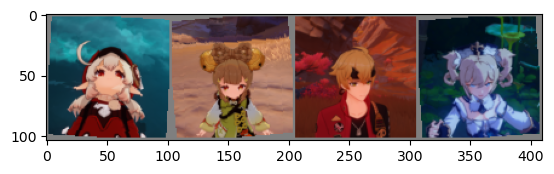

tensor(14)
tensor(35)
tensor(31)
tensor(2)


In [6]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

for i in labels:
    print(i)

In [8]:
class MKNet(nn.Module):
    def __init__(self):
        super(MKNet, self).__init__()
        self.conv1A = nn.Conv2d(3, 32, 3, padding=1)    # (3, 100, 100) -> (64, 100, 100)
        #self.conv1B = nn.Conv2d(32, 32, 3, padding=1)   # -> (64, 100, 100)
        self.pool1 = nn.MaxPool2d(2, 2)                 # -> (64, 50, 50)
        
        self.conv2A = nn.Conv2d(32, 64, 3, padding=1)    # -> (128, 50, 50)
        #self.conv2B = nn.Conv2d(64, 64, 3, padding=1)    # -> (128, 50, 50)
        self.pool2 = nn.MaxPool2d(2, 2)                 # -> (128, 25, 25)
        
        self.conv3A = nn.Conv2d(64, 128, 3, padding=1)   # -> (256, 25, 25)
        #self.conv3B = nn.Conv2d(128, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)                 # -> (256, 12, 12)

        self.conv4A = nn.Conv2d(128, 256, 3, padding=1)  # -> (512, 12, 12)
        self.conv4B = nn.Conv2d(256, 256, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)                 # -> (512, 6, 6)

        self.conv5A = nn.Conv2d(256, 512, 3, padding=1)  # -> (512, 12, 12)
        self.conv5B = nn.Conv2d(512, 512, 3, padding=1)  # -> (512, 12, 12)
        self.pool5 = nn.MaxPool2d(2, 2)                 # -> (512, 3, 3)

        self.fc1 = nn.Linear(512*3*3, 256) #Fully connected layer
        self.fc2 = nn.Linear(256, 64) #Fully connected layer
        self.fc3 = nn.Linear(64, 64) #Fully connected layer
        self.fc4 = nn.Linear(64, len(classes)) #Fully connected layer

    def forward(self,x):
        
        x = self.conv1A(x)
        x = torch.relu(x)
        # x = self.conv1B(x)
        # x = torch.relu(x)
        x = self.pool1(x)

        x = self.conv2A(x)
        x = torch.relu(x)
        # x = self.conv2B(x)
        # x = torch.relu(x)
        x = self.pool2(x)

        x = self.conv3A(x)
        x = torch.relu(x)
        # x = self.conv3B(x)
        # x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4A(x)
        x = torch.relu(x)
        x = self.conv4B(x)
        x = torch.relu(x)
        x = self.pool4(x)


        x = self.conv5A(x)
        x = torch.relu(x)
        x = self.conv5B(x)
        x = torch.relu(x)
        x = self.pool5(x)

        x = x.view(x.size(0),-1) #Flatten the tensor

        x = self.fc1(x)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)
        x = torch.relu(x)

        x = self.fc4(x)

        return x     

In [9]:
model = MKNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
loss_history = []
steps = len(train_loader)
for epoch in range(EPOCHS):
    running_loss = 0
    current_step = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        images = images.to(DEVICE)

        #Forward
        outputs = model(images)
        loss = criterion(outputs,labels)

        #Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_step += 1
        if(current_step%200 == 0):
            print(f'Step: {current_step}/{steps} Step Loss: {loss.item()}')
        running_loss += loss.item()
    avg_loss = running_loss / steps
    loss_history.append(avg_loss)
    print (f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}')
PATH = './models/' + TRAIN_DATA_PATH.split('/')[-1] + '.pth'
torch.save(model.state_dict(), PATH)

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(loss_history, marker='o',color='turquoise')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()
        

KeyboardInterrupt: 

Accuracy Test Result:
alhaitham  → 100.00%
amber      → 100.00%
barbara    → 100.00%
beidou     → 100.00%
bennett    → 100.00%
collei     → 100.00%
diluc      → 100.00%
diona      → 100.00%
dori       → 100.00%
fischl     → 100.00%
ganyu      → 100.00%
gorou      → 100.00%
jean       → 100.00%
kaeya      → 100.00%
klee       → 100.00%
kujou_sara → 97.37%
kuki_shinobu → 100.00%
layla      → 100.00%
lisa       → 100.00%
lumine     → 100.00%
mona       → 100.00%
nahida     → 100.00%
ningguang  → 100.00%
noelle     → 100.00%
raiden_shogun → 100.00%
razor      → 100.00%
rosaria    → 100.00%
sangonomiya_kokomi → 100.00%
sayu       → 100.00%
shikanoin_heizou → 100.00%
sucrose    → 100.00%
thoma      → 100.00%
xiangling  → 100.00%
xingqiu    → 100.00%
xinyan     → 100.00%
yaoyao     → 100.00%
yoimiya    → 100.00%
yun_jin    → 100.00%
Overall Accuracy: 99.93%


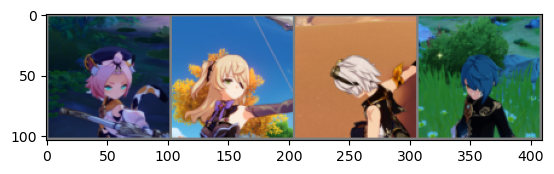

Actual:  diona | fischl | bennett | xingqiu
Predicted:     diona | fischl | bennett | xingqiu


In [16]:
import random

model.load_state_dict(torch.load(('./models/genshin/' + TRAIN_DATA_PATH.split('/')[-1] + '.pth'), map_location=torch.device(DEVICE)))
model.eval()

transform_no_preprocess= transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
     transforms.Resize((100,100))]
)

test_dataset = torchvision.datasets.ImageFolder(
    root=TEST_DATA_PATH,
    transform=transform_no_preprocess,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=g,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id),
)

correct_pred = [0] * len(classes)
total_pred = [0] * len(classes)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for label, prediction in zip(labels, predicted):
            
            total_pred[label] += 1
            if label == prediction:
                correct_pred[label] += 1

print("Accuracy Test Result:")
for i in range(len(classes)):
    if correct_pred[i] == 0:
        accuracy = 0
    else:
        accuracy = 100 * correct_pred[i] / total_pred[i]
    print(f"{classes[i]:10s} → {accuracy:.2f}%")

overall_correct = sum(correct_pred)
overall_total = sum(total_pred)

overall_accuracy = overall_correct / overall_total
print(f"Overall Accuracy: {100*overall_accuracy:.2f}%")


# Get one batch
dataiter = iter(test_loader)
images, labels = next(dataiter)
images_display = images  # save a copy before pushing to GPU
images, labels = images.to(DEVICE), labels.to(DEVICE)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images_display))
print(f'Actual: ', ' | '.join(f'{classes[labels[j]]}' for j in range(BATCH_SIZE)))
print(f'Predicted:    ', ' | '.join(f'{classes[predicted[j]]}' for j in range(BATCH_SIZE)))
